Нужно защитить данные клиентов страховой компании «Хоть потоп» путем разработки метода преобразования данных, чтобы по ним было сложно восстановить персональную информацию. При этом нужно, чтобы при преобразовании качество моделей машинного обучения не ухудшилось.

# План работы

1. Загрузка данных
2. Умножение матриц
3. Алгоритм преобразования
4. Проверка алгоритма <br/>
    4.1. Исходная матрица <br/>
    4.2. Пребразованная матрица <br/>

## 1. Загрузка данных

In [1]:
#импортируем библиотеки
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import os
import urllib.request
import warnings 
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [2]:
#загружаем данные
Path('datasets').mkdir(parents=True, exist_ok=True)

def get_file(file_name, url):
    if not os.path.exists(file_name):
        print(file_name, 'файл не найден, будет загружен из сети')
        _=urllib.request.urlretrive(url, file_name)
        
urls = {
    'insurance': ('/datasets/insurance.csv', 'https://code.s3.yandex.net/datasets/insurance.csv')
}

[get_file(*urls[k]) for k in urls]

df = pd.read_csv(urls['insurance'][0])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


In [3]:
df.describe()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


In [4]:
df.duplicated().sum()

153

In [5]:
df = df.drop_duplicates().reset_index(drop=True)
df.duplicated().sum()

0

In [6]:
df.corr()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
Пол,1.000000,0.001953,0.015456,-0.007315,0.011565
Возраст,0.001953,1.000000,-0.017386,-0.009064,0.654964
Зарплата,0.015456,-0.017386,1.000000,-0.031687,-0.013123
Члены семьи,-0.007315,-0.009064,-0.031687,1.000000,-0.039303
Страховые выплаты,0.011565,0.654964,-0.013123,-0.039303,1.000000


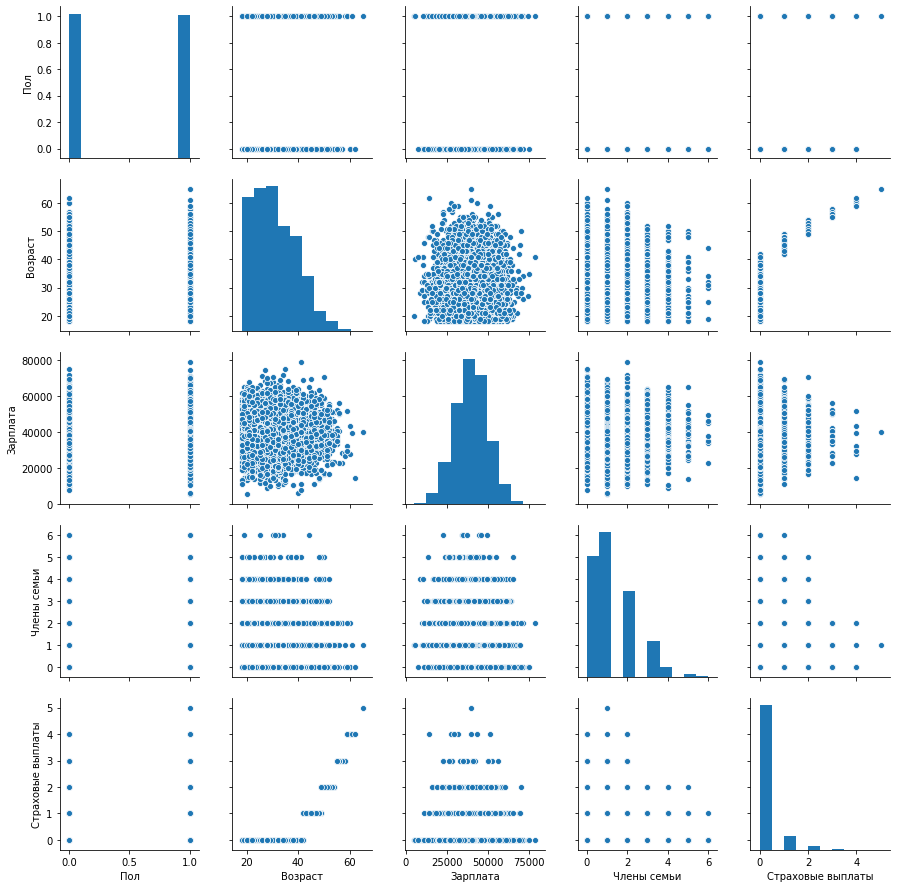

In [7]:
sns.pairplot(df)
plt.show()

- Всего в датасете 5 000 объектов и 5 признаков
- Пропусков не имеется, 153 дубликатов удалили, данные между собой не коррелируют

## 2. Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $XM$ — преобразованная матрица

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$ y = Xw $$

Задача обучения:

$$ w = \arg\min_w MSE(Xw, y) $$

Формула обучения:

$$ w = (X^T X)^{-1} X^T y $$

Полная формула предсказания, весы представим через матрицу:

$$ y = X(X^T X)^{-1} X^T y $$

Подставляем на место исходной матрицы преобразованную:

$$ y = XM((XM)^T XM)^{-1} (XM)^T y $$

Распишем формулу шаг за шагом:

$$ y = X M(X^T M^T X M)^{-1} X^T M^T y $$
$$ y = X M(X^T X)^{-1} M^{-1}(M^T)^{-1}X^T M^T y $$

Переставим матрицы:
$$ y = X(X^T X)^{-1}M M^{-1}(M^T)^{-1}M^T X^T y $$

Произведения матрицы A (в данном случае M и M^T) умноженной на ее обратную A^{-1} равно единчиной матрицу E
$$ y = X(X^T X)^{-1}E E X^T y $$

В результате, получаем изначальную формулу с формулой весов через матрицу:
$$ y = X(X^T X)^{-1}X^T y $$
$$ y = Xw $$

## 3. Алгоритм преобразования

**Алгоритм**

1) Создаём рандомную матрицу<br>
2) Проверяем её на обратимость (создаём единичную матрицу)<br>
3) Создаём новую матрицу данных<br>
4) Ищем метрики качества на исходных данных и на преобразованных<br>
5) Делаем вывод<br>

**Обоснование**

В предыдущем пункте доказали, что при умножении матрицы формула и, соответственно, результаты не изменяются.

## 4. Проверка алгоритма

### 4.1. Исходная матрица

In [8]:
# разделим данные на обучающие признаки и целевой
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']

print(features.shape)
print(target.shape)

(4847, 4)
(4847,)


In [9]:
# подготовим обучающий и тестовый выборки
x_test, x_train, y_test, y_train = train_test_split(
    features, target, test_size=0.75, random_state=12345)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(3636, 4)
(1211, 4)
(3636,)
(1211,)


In [10]:
# проверим модель из библиотеки scikit
model = LinearRegression()
pred = model.fit(x_train, y_train).predict(x_test)
print('r2 score: {:.3f}'.format(r2_score(y_test, pred)))

r2 score: 0.428


### 4.2. Пребразованная матрица

In [11]:
# создадим случайную матрицу и проверим на обратимость
m = np.random.normal(16, size = (4, 4))
m_inv = np.linalg.inv(m)
m_inv

array([[ 2.04003980e-01,  3.15317711e-01, -1.46269037e-03,
        -4.69570596e-01],
       [ 2.32007718e+00, -8.82651148e-01,  7.48571795e-01,
        -2.05153823e+00],
       [-7.68428209e-01,  4.84562818e-01, -6.21489413e-01,
         8.77036473e-01],
       [-1.85904125e+00,  1.53798094e-01, -1.75469453e-01,
         1.78022422e+00]])

In [12]:
# умножим признаки на случайную обратимую матрицу
features_m = np.dot(features, m_inv)
xm_test, xm_train, y_test, y_train = train_test_split(
    features, target, test_size=0.75, random_state=12345)

print(xm_train.shape)
print(xm_test.shape)

(3636, 4)
(1211, 4)


In [13]:
# проверим метрику качества
model = LinearRegression()
pred_m = model.fit(xm_train, y_train).predict(xm_test)
print('r2 score: {:.3f}'. format(r2_score(y_test, pred_m)))

r2 score: 0.428


Метрика качества модели на обучающей исходной и преобразованной матрице в обоих случаях равны — 0.428

## Вывод


Была проделана следующая работа:
- загружены и изучены данные: после удаления 154 дубликатов, в данных осталось 4 847 наблюдений и 5 признаков
- далее математической формулой доказали, что при умножении на обратимую матрицу, ее произведение приведет к единчиной матрице и в результате качество линейной регресии не изменится
- проверили на практике теорию: r2 score при обучении на исходной и преобразованной матрице одинакова и составляет 0.428

Если рассматривать передачу данных третьим лицам, то к преимуществам данного подхода можно отнести, в первую очередь, ощутимую экономию ресурсов по сравнению с некоторыми известными алгоритмами шифрования, в особенности это касается ассиметричных алгоритмов с достаточно длинными ключами (AES, RSA), которые требуют много процессорного времени.

К главному недостатку подхода можно отнести увеличение сложности проверки на вырожденность преобразования с ростом количества признаков в выборке. В рассмотренном случае необходимо подобрать подходящую матрицу размера 4×4 . Однако, если признаки будут исчисляться тысячами, что в теории всегда надо положить, то расчет соответствующих определителей может быть крайне ресурсозатратным. Но и эту проблему можно будет решить)